###Blobs. A project of Urban CCD in Chicago
#Tutorial 1.0 - Using Static Data

##Data Prep and Set-Up
   You should have already cloned the blobs repo from GitHub, and saved it accordingly. The first steps import the required libraries, assign and initilize the required data and spatial files. Your data will be connected to spatial files, connecting 311 call data to census tracts in this case.

In [127]:
cd blobs

/Users/laurendyson/Sites/blobs


In [230]:
# Import required libraries and assign root directory of blobs to root
import blobs
import numpy as np
import pandas as pd
import pysal as ps
import os

root = os.getcwd()
%pylab inline
SHAPE_FILE = root + '/virginia_tracts.shp'
DBF_FILE = root + '/virginia_tracts.dbf'
DATA_FILE = root + '/virginia_weighted.csv'
WEIGHT_FILE = None #root + 'zip_code/custom_zip_weight_file.gal'
SHAPE_GEO_ID = 'GEO_ID'
DATA_GEO_ID = 'geo_id'

Populating the interactive namespace from numpy and matplotlib


In [231]:
# Open census tract shapefile and database.
shp_link = SHAPE_FILE
dbf = ps.open(DBF_FILE)

In [232]:
# Shapefile and data preparation.
cols = np.array([dbf.by_col(col) for col in dbf.header]).T
df = pd.DataFrame(cols)
df.columns = dbf.header
df['order'] = df.index

In [233]:
# Assign spatial weight for census tracts.

if WEIGHT_FILE:
    w=ps.open(WEIGHT_FILE).read()
else:
    w = ps.knnW_from_shapefile(SHAPE_FILE, idVariable=SHAPE_GEO_ID) #KNN vs. Rook

In [234]:
# Initialize sample 311 call data from CSV file.
init_calls = pd.read_csv(DATA_FILE, dtype=object)
for c in init_calls.columns[1:]:
    init_calls[c] = init_calls[c].astype('float')

In [240]:
df.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,order
0,1400000US51051040200,51,051,040200,402,Tract,48.562,0
1,1400000US51051040400,51,051,040400,404,Tract,134.618,1
2,1400000US51057950600,51,057,950600,9506,Tract,158.966,2
3,1400000US51059415100,51,059,415100,4151,Tract,0.92,3
4,1400000US51059415401,51,059,415401,4154.01,Tract,0.625,4


In [241]:
init_calls.head()

,geo_id,VAP_PI,VAP_NA,TOTPOP_WNH,TOTPOP,TOTPOP_PI,VAP,TOTPOP_NA,VAP_WNH,VAP_H,TOTPOP_B,TOTPOP_A,VAP_A,VAP_B,TOTPOP_H,PRS08_REP_per,PRS08_DEM_per,GOV09_DEM_per,GOV09_REP_per
0,1400000US51001090100,0,57,2764,2941,0,2487,66,2357,31,44,28,22,27,49,0.487330,0.239071,0.119228,0.310768
1,1400000US51001090200,15,63,3897,6156,22,4922,78,3250,106,1956,57,37,1467,179,0.266607,0.288594,0.097802,0.174321
2,1400000US51001090300,2,26,1669,2335,2,1814,29,1356,93,465,11,9,326,152,0.310006,0.197299,0.070182,0.195507
3,1400000US51001090400,10,27,2331,6234,16,4704,38,1931,907,2358,39,27,1829,1486,0.191679,0.291046,0.112483,0.133986
4,1400000US51001090500,8,24,1619,2849,13,2164,38,1289,238,768,33,19,598,405,0.275305,0.263295,0.110365,0.188826


In [246]:
# Format data and merge on shapefile IDs
ordered_tracts = pd.DataFrame(df.loc[:,[SHAPE_GEO_ID, 'order']])
calls = pd.merge(init_calls, ordered_tracts, how='right', left_on=DATA_GEO_ID, 
    right_on= SHAPE_GEO_ID, sort=False).fillna(0).sort(['order'])
calls = calls.drop(['order', 'GEO_ID'],1)

class bd:
  data = calls
  w = w
  shp_link = shp_link
  id = 'geo_id'
  level = 'tract'

In [247]:
calls.head()

,geo_id,VAP_PI,VAP_NA,TOTPOP_WNH,TOTPOP,TOTPOP_PI,VAP,TOTPOP_NA,VAP_WNH,VAP_H,TOTPOP_B,TOTPOP_A,VAP_A,VAP_B,TOTPOP_H,PRS08_REP_per,PRS08_DEM_per,GOV09_DEM_per,GOV09_REP_per
287,1400000US51051040200,1,12,2836,2895,1,2291,13,2247,13,14,8,6,7,16,0.293186,0.246460,0.096958,0.191545
289,1400000US51051040400,1,11,3111,3156,1,2451,14,2418,10,8,9,6,6,15,0.281632,0.212562,0.088956,0.191677
297,1400000US51057950600,2,54,2000,3865,2,3015,69,1603,64,1717,20,16,1309,99,0.228073,0.422285,0.151154,0.143745
300,1400000US51059415100,4,22,2333,3411,9,2568,27,1781,404,336,166,128,251,576,0.290997,0.412488,0.205249,0.233590
303,1400000US51059415401,18,43,1555,5135,24,3835,61,1288,871,1855,467,349,1335,1296,0.155977,0.396138,0.156021,0.093945


In [248]:
# Assign the attribute data.
d = bd()

##Create Blobs
You can assign what attribute you would like to "blob" accordingly. In example 1, blobs are created from census tracts and must have a minimum of 10,000 persons per blob.

['VAP_PI', 'VAP_NA', 'TOTPOP_WNH', 'TOTPOP', 'TOTPOP_PI', 'VAP', 'TOTPOP_NA', 'VAP_WNH', 'VAP_H', 'TOTPOP_B', 'TOTPOP_A', 'VAP_A', 'VAP_B', 'TOTPOP_H', 'PRS08_REP_per', 'PRS08_DEM_per', 'GOV09_DEM_per', 'GOV09_REP_per']

### CREATING BLOBS FROM 18 VARIABLES ###
    PARAMETERS:
     # Minimum TOTPOP in each blob: 5000
     # Iterations: 1
     # Method: equal votes
     # Plot blobs: True
     # Save blobs data: False


# ITERATION 1                 
  Score: 6728.35
  Created 952 blobs (2 tracts per blob)
  Best solution so far: 6728.35
  Time taken: 9.0 seconds (0 seconds remaining)

# BEST SOLUTION:                      
  Score: 6728.35
  952 blobs (2 tracts per blob)
  Plotting...


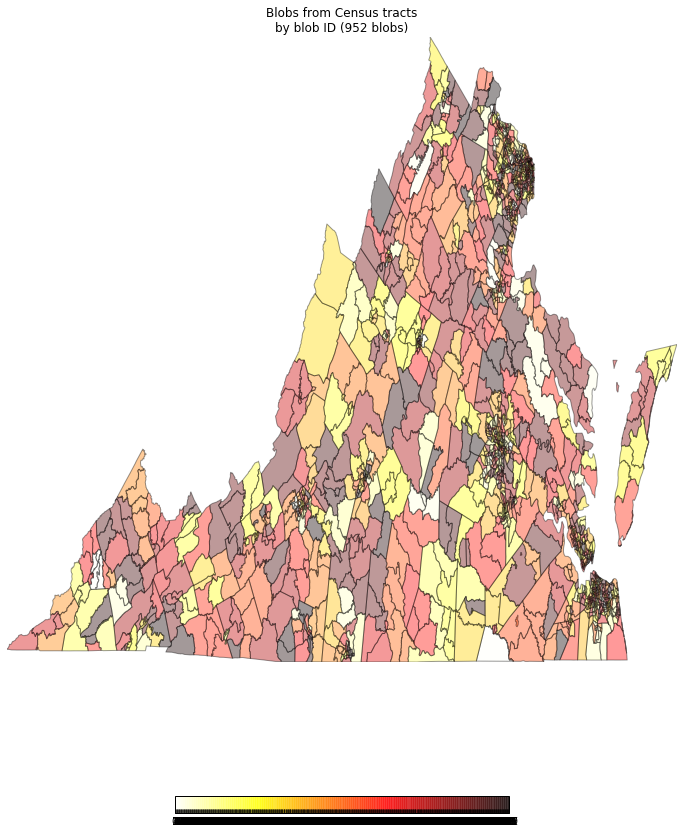

In [249]:
# Example 1: Create blobs minimum population of 10,000 in each blob. This calls a Pop-Up Window with the Map.
b = blobs.Blobs(d, 'TOTPOP', 5000, iterations=1)

  Plotting...


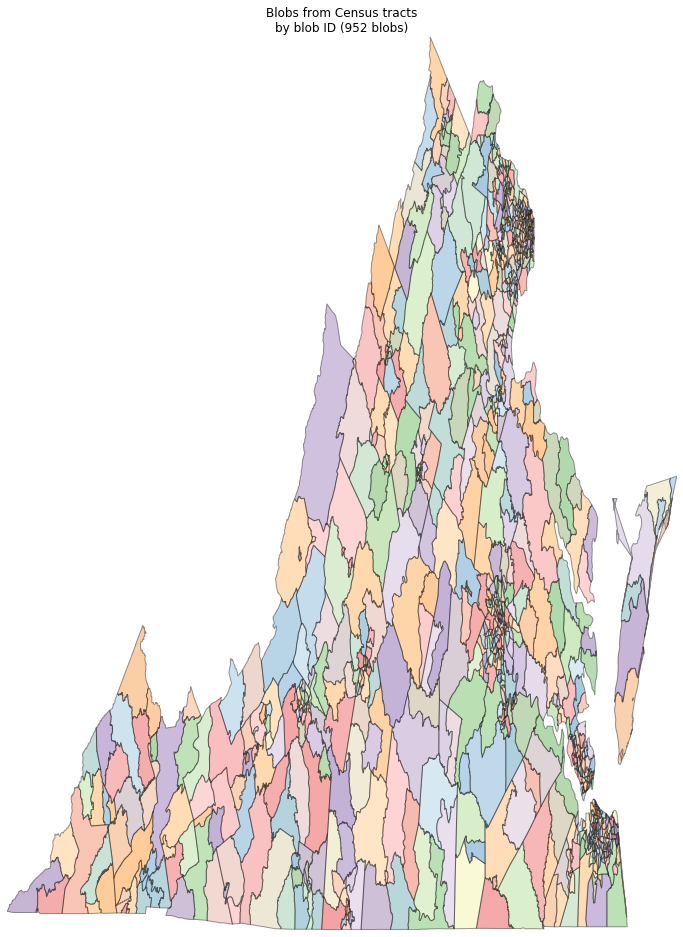

In [250]:
#output a shape file for the generated blobs. Visualize the blobs map
b.generate_shapefile(filename='virginia_8000pop.shp')
b.plot_blobs(blob_shp = 'virginia_8000pop.shp')

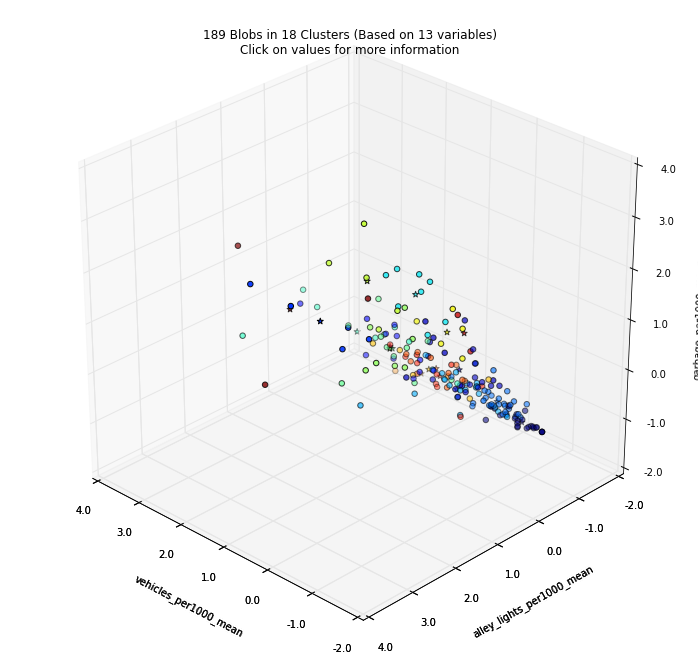

In [11]:
# Cluster the blobs along similarities in the data
cl = blobs.Cluster_blobs(b, blobs_per_cluster=10)

In [12]:
# See the cluster assignment for each blob
cl.assignments

array([ 1, 15,  5,  8, 14,  3,  1,  1,  7,  3,  4,  1,  6,  4,  5,  9, 13,
        0,  4,  0,  9,  0, 15,  0,  4,  0, 14,  4,  7, 17,  2,  1,  8,  7,
        4, 14,  8,  1,  4,  5, 11,  1, 15,  0,  4,  1,  4, 16, 10,  4,  5,
        5,  1,  4,  6,  7,  2,  0, 15,  8,  2, 16,  9,  6,  5,  0,  5,  8,
        5,  2, 17,  5, 15,  0,  9, 12,  2,  5,  0, 15,  4,  5,  4,  6,  1,
        0, 11,  1,  1,  3,  9, 17,  7, 11,  5,  4,  4,  8,  2,  8,  5,  1,
       10,  2,  4,  6,  0,  2,  3,  0,  4,  1,  1,  2,  9,  7,  5, 11,  1,
        0, 13, 14,  5,  5, 12,  4,  4,  5,  8,  4,  4,  5,  4,  4,  0,  6,
        1, 14, 14,  8, 14,  9,  5,  0,  4,  4,  6,  0, 12,  4,  7,  0,  1,
        0,  0, 10,  4, 14,  0,  5,  6,  1,  3,  1,  2, 11,  8, 15,  0, 12,
        1,  1, 10, 15,  2, 14, 15,  4,  4, 14, 10,  5,  0,  0,  4,  8, 15,
       15, 12], dtype=int32)

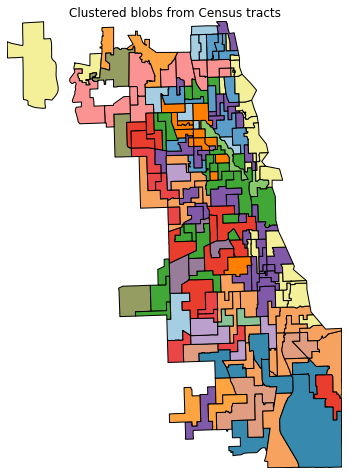

In [13]:
#visualize the blobs after clustering. Blobs within a cluster have same color.
cl.plot_map(blob_shp='blob_test_1.shp')

You can assign what attribute you would like to "blob" accordingly. In example 2, blobs are created from census tracts and must have a minimum of 30 census tracts per blob.

['vehicles_per1000', 'alley_lights_per1000', 'garbage_per1000', 'graffiti_per1000', 'potholes_per1000', 'rodents_per1000', 'sanitation_per1000', 'street_lights_one_per1000', 'street_lights_all_per1000', 'tree_debris_per1000', 'tree_trims_per1000', 'buildings_per1000', 'all_calls_per1000']

### CREATING BLOBS FROM 13 VARIABLES ###
    PARAMETERS:
     # Minimum areas in each blob: 20
     # Iterations: 1
     # Method: equal votes
     # Plot blobs: True
     # Save blobs data: False


# ITERATION 1                 
  Score: 5463.65
  Created 33 blobs (24 tracts per blob)
  Best solution so far: 5463.65
  Time taken: 12.3 seconds (0 seconds remaining)

# BEST SOLUTION:                      
  Score: 5463.65
  33 blobs (24 tracts per blob)
  Plotting...


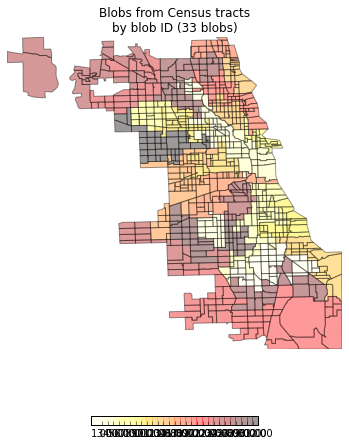

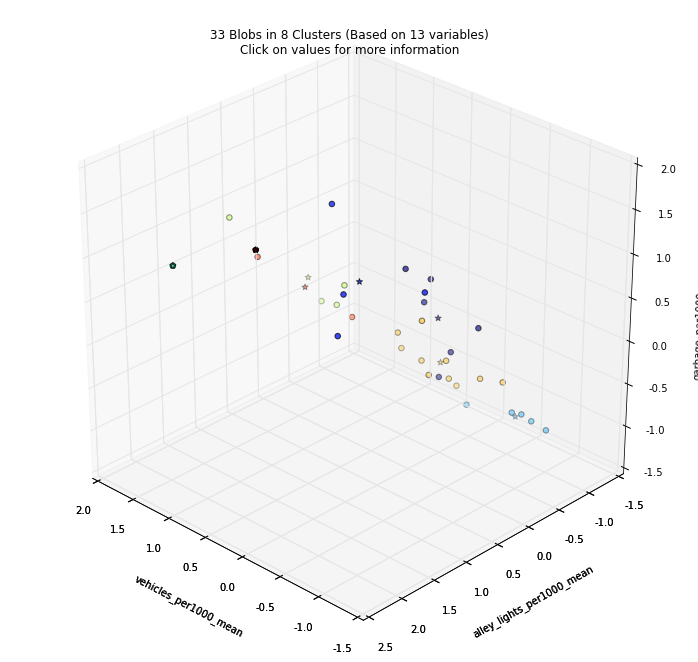

In [14]:
# Create blobs with a minimum of 20 tracts in each blob, and cluster
b = blobs.Blobs(d, 'areas', 20,iterations=1)
cl = blobs.Cluster_blobs(b, blobs_per_cluster=4)

  Plotting...


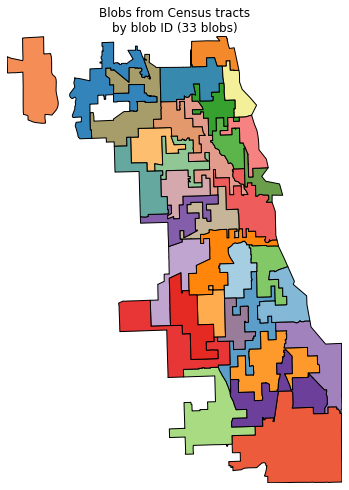

In [15]:
#output a shape file for the generated blobs. Visualize the blobs map
b.generate_shapefile(filename='blob_test_2.shp')
b.plot_blobs(blob_shp = 'blob_test_2.shp')

In [16]:
# See blob assignments
cl.assignments

array([1, 5, 0, 5, 0, 2, 4, 2, 2, 5, 5, 0, 5, 2, 5, 0, 6, 5, 2, 5, 1, 1, 4,
       3, 5, 5, 4, 7, 4, 6, 0, 0, 1], dtype=int32)

  Plotting...


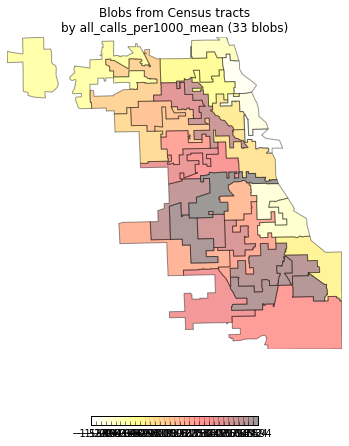

In [17]:
# Plot blobs along one of the variables
b.plot_blobs(blob_shp='blob_test_2.shp',variable='all_calls_per1000_mean')

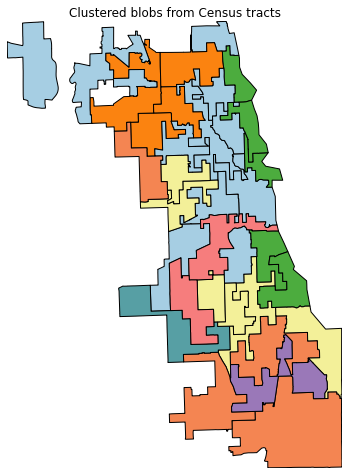

In [18]:
#visualize the blobs after clustering. Blobs within a cluster have same color.
cl.plot_map(blob_shp='blob_test_2.shp')